In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dictionary-of-english-words-and-definitions/dict.csv


# Dataset overview

In [2]:
input_filepath = "/kaggle/input/dictionary-of-english-words-and-definitions/dict.csv"
df = pd.read_csv(input_filepath)
df.dropna(inplace=True)
df['definition_len'] = df['definition'].apply(len)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42050 entries, 0 to 42051
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   word            42050 non-null  object
 1   definition      42050 non-null  object
 2   definition_len  42050 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


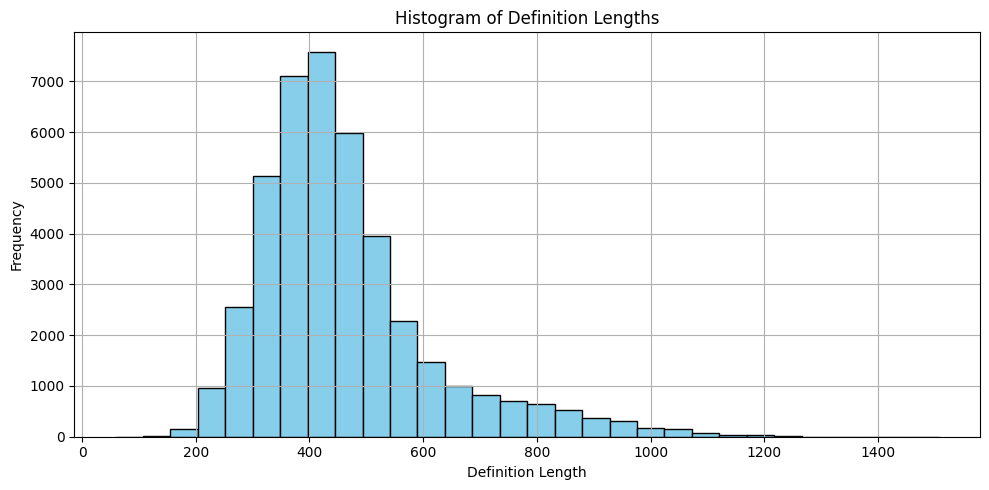

In [3]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(df['definition_len'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Definition Lengths')
plt.xlabel('Definition Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
temp = pd.read_csv("hf://datasets/MLBtrio/genz-slang-dataset/all_slangs.csv")
temp.head()

,Slang,Description,Example,Context
0,W,Shorthand for win,"Got the job today, big W!",Typically used in conversations to celebrate s...
1,L,Shorthand for loss/losing,"I forgot my wallet at home, that’s an L.",Often used when referring to a failure or mish...
2,L+ratio,Response to a comment or action on the interne...,Your tweet got 5 likes and 100 replies calling...,Popularized on social media platforms to signi...
3,Dank,excellent or of very high quality,That meme is so dank!,Commonly used in internet slang to refer to me...
4,Cheugy,Derogatory term for Millennials. Used when mil...,"That phrase is so cheugy, no one says that any...",Used to refer to things that were once popular...


# Dataset helpers

In [5]:
import torch
from torch.utils.data import Dataset
import json
from tqdm import tqdm
import pandas as pd
from torch.utils.data import random_split, DataLoader


class MyDataset(Dataset):
    def __init__(self,csv_path, tokenizer, embeddings):
        assert (isinstance(csv_path, str) and csv_path.endswith("csv"))

        self.tok = tokenizer
        self.emb = embeddings
        self.samples = []

        df = pd.read_csv(csv_path)
        df.dropna(inplace=True)
        df['definition_len'] = df['definition'].apply(len)
        df = df.sort_values(by='definition_len', ascending=True).reset_index(drop=True).head(42048)
        
        input_defns, ground_truths = [], []
        for index, row in tqdm(df.iterrows(), total=len(df), desc="Collecting the ground truths."):
            word, definition = row['word'], row['definition']
            word_emb = self.extract_embeddings(word)
            ground_truths.append(word_emb)
            input_defns.append(definition)

        assert len(input_defns) == len(ground_truths)

        for i in tqdm(range(len(ground_truths)), desc="Creating the samples."):
            # X = self.tok(input_defns[i], padding="max_length", return_tensors='pt')
            tokenized = self.tok(input_defns[i], padding="max_length", return_tensors='pt')
            X = {
                'input_ids': tokenized['input_ids'].squeeze(0),
                'attention_mask': tokenized['attention_mask'].squeeze(0)
            }
            y = ground_truths[i].to(torch.float32)
            self.samples.append((X,y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    
    def extract_embeddings(self, word):
        text_ind = self.tok.encode(word, add_prefix_space=True)
        embed = self.emb[text_ind, :].detach()

        if len(text_ind) > 1:
            embed_avg = torch.stack(embed.unbind()).mean(dim=0)
            return embed_avg

        return embed.squeeze(dim=0)


def split_data(dataset, batch_size=16):
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    train_dl, val_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True), DataLoader(val_set, batch_size=batch_size, shuffle=False)
    return train_dl, val_dl


def process_genz_slang(top_k = 512):
    df = pd.read_csv("hf://datasets/MLBtrio/genz-slang-dataset/all_slangs.csv")
    df['Slang'] = df['Slang'].apply(lambda x: x.lower())
    df['Description'] = df['Description'].apply(lambda x: x.lower())
    df['Example'] = df['Example'].apply(lambda x: x.lower())
    df['Context'] = df['Context'].apply(lambda x: x.lower())
    
    df['Slang_Length'] = df['Slang'].apply(len)
    filtered_df = df[(df['Slang_Length'] >= 3) & (~df['Slang'].str.contains(' '))]
    final = filtered_df.sort_values(by='Slang_Length', ascending=False).reset_index(drop=True).head(top_k)
    final['new_context'] = final['Description'] + ', ' + final['Context']
    
    return final

# Finetune the model

In [6]:
import os
import sys
import json
import torch
from torch.utils.data import random_split, DataLoader
from datetime import datetime
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoModelForMultipleChoice
import logging
import pandas as pd
from tqdm import tqdm
import gc

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(levelname)s | %(message)s',
    stream=sys.stderr
)

logger = logging.getLogger(__name__)


os.makedirs('/kaggle/working/gpt2-finetuned-dictionary', exist_ok=True)
os.makedirs('/kaggle/working/gpt2-genz-vocab', exist_ok=True)

# =========================================================
# hyperparameters and configurations

device = "cuda" if torch.cuda.is_available() else "cpu"
logger.info(f"Using {device} device")

csv_filepath = "/kaggle/input/dictionary-of-english-words-and-definitions/dict.csv"

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
log_interval = 4  # Log every 1 optimization steps

learning_rate = 3e-5 
epochs = 3
data_loader_batch_size = 8
grad_accum_steps = 32
# 8 examples in a batch * 1024 token long sequence per example * 32 times = 262144 tokens per effective batch

# Clear GPU cache at start
torch.cuda.empty_cache()

# =========================================================
# Initialize the model
model = GPT2LMHeadModel.from_pretrained('gpt2', output_hidden_states=True)
model = model.to(device)
word_embeddings = model.transformer.wte.weight

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model.resize_token_embeddings(len(tokenizer))


# =========================================================
loss_train = {
    "loss": [],
    "step": []
}

train_val_loss = {
    "train": [],
    "val": [],
    "ep": []
}
# =========================================================
# Get the dataloader
word_definition_ds = MyDataset(csv_filepath, tokenizer, word_embeddings)
train_dl, val_dl = split_data(word_definition_ds, data_loader_batch_size)

2025-06-01 09:01:51.771299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748768512.234989      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748768512.362626      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-01 09:02:09,079 | INFO | Using cuda device


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
Creating the samples.: 100%|██████████| 42048/42048 [00:53<00:00, 780.20it/s]


# Phase 1: Finetune on the word-definition pairs

In [7]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

best_vloss, trained_model_path = float('inf'), None

for ep in range(epochs):
    logger.info(f"Epoch: {ep+1}")
    
    # One pass through data
    model.train(True)
    accumulated_loss = 0.0
    optimization_step = 0  # Track actual optimization steps
    
    # Initialize gradients
    optimizer.zero_grad()
    
    for i, data in enumerate(train_dl):
        try:
            def_tokens, label = data
            def_tokens['input_ids'] = def_tokens['input_ids'].to(device)
            def_tokens['attention_mask'] = def_tokens['attention_mask'].to(device)
            label = label.to(device)
            
            # Forward pass
            with torch.autocast(device_type=device, dtype=torch.float16):
                output = model(input_ids=def_tokens['input_ids'], 
                             attention_mask=def_tokens['attention_mask'])
                
                # Get last hidden state
                hidden_states = output.hidden_states[-1]
                last_hidden_state = hidden_states[:, 0, :]
                
                loss = loss_fn(last_hidden_state, label)
                # Scale loss for gradient accumulation
                loss = loss / grad_accum_steps
            
            # Backward pass
            loss.backward()
            accumulated_loss += loss.item()  # Keep scaled loss for accurate accumulation
            
            # Gradient accumulation step - THIS IS WHERE ACTUAL TRAINING HAPPENS
            if (i + 1) % grad_accum_steps == 0:
                # Clip gradients and step
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()
                optimization_step += 1
                
                # Calculate actual loss for this optimization step (unscaled)
                step_loss = accumulated_loss  # This is already the average over grad_accum_steps
                accumulated_loss = 0.0  # Reset for next accumulation
                
                # Logging - ONLY when we actually optimize
                if optimization_step % log_interval == 0:
                    logger.info(f'  optimization step {optimization_step} (batch {i + 1}) loss: {step_loss:.6f}')
                    tb_x = ep * (len(train_dl) // grad_accum_steps) + optimization_step
                    loss_train['loss'].append(step_loss)
                    loss_train['step'].append(tb_x)
                    
                    # # Memory status logging
                    # if torch.cuda.is_available():
                    #     memory_allocated = torch.cuda.memory_allocated(device) / 1024**3
                    #     memory_reserved = torch.cuda.memory_reserved(device) / 1024**3
                    #     logger.info(f'  GPU Memory - Allocated: {memory_allocated:.2f}GB, Reserved: {memory_reserved:.2f}GB')
                
                # Clear cache periodically
                if optimization_step % 4 == 0:  # Every 4 optimization steps
                    torch.cuda.empty_cache()
                    gc.collect()
        
        except torch.cuda.OutOfMemoryError:
            logger.error(f"CUDA OOM at batch {i+1}. Clearing cache and skipping batch.")
            torch.cuda.empty_cache()
            gc.collect()
            optimizer.zero_grad()
            accumulated_loss = 0.0  # Reset accumulated loss
            continue
    
    # Handle any remaining gradients at epoch end
    final_step_loss = None
    if accumulated_loss > 0 and (len(train_dl)) % grad_accum_steps != 0:
        # We have some accumulated gradients that haven't been stepped
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()
        optimization_step += 1
        final_step_loss = accumulated_loss
        logger.info(f'  final optimization step {optimization_step} loss: {final_step_loss:.6f}')
    
    # Use the last logged loss or final step loss for epoch summary
    if len(loss_train['loss']) > 0:
        epoch_avg_loss = loss_train['loss'][-1]  # Last logged loss
    elif final_step_loss is not None:
        epoch_avg_loss = final_step_loss
    else:
        epoch_avg_loss = 0.0
    
    # Validation phase
    model.train(False)
    running_vloss, val_count = 0.0, 0
    
    # Clear cache before validation
    torch.cuda.empty_cache()
    gc.collect()
    
    with torch.no_grad():
        for i, vdata in enumerate(val_dl):
            try:
                vinputs, vlabels = vdata
                vinputs['input_ids'] = vinputs['input_ids'].to(device)
                vinputs['attention_mask'] = vinputs['attention_mask'].to(device)
                vlabels = vlabels.to(device)
                
                with torch.autocast(device_type=device, dtype=torch.float16):
                    voutputs = model(input_ids=vinputs['input_ids'], 
                                   attention_mask=vinputs['attention_mask'])
                    vhidden_states = voutputs.hidden_states[-1]
                    vlast_hidden_state = vhidden_states[:, 0, :]
                    vloss = loss_fn(vlast_hidden_state, vlabels)
                
                running_vloss += vloss.item()
                val_count += 1
                
                # Clear cache periodically during validation
                if (i + 1) % 10 == 0:
                    torch.cuda.empty_cache()
                    
            except torch.cuda.OutOfMemoryError:
                logger.error(f"CUDA OOM during validation at batch {i+1}. Skipping.")
                torch.cuda.empty_cache()
                gc.collect()
                continue
    
    if val_count > 0:
        avg_vloss = running_vloss / val_count
    else:
        avg_vloss = float('inf')
    
    logger.info(f'EPOCH {ep+1} - Optimization steps: {optimization_step}, Train loss: {epoch_avg_loss:.6f}, Validation loss: {avg_vloss:.6f}')

    # Log the epoch summary
    train_val_loss['train'].append(epoch_avg_loss)
    train_val_loss['val'].append(avg_vloss)
    train_val_loss['ep'].append(ep+1)

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'gpt2_finetuned_model_{timestamp}_{ep}'
        torch.save(model.state_dict(), model_path)
        trained_model_path = model_path

# Final cleanup
torch.cuda.empty_cache()
gc.collect()

# =========================================================
# Save the training loss for the visualization
with open('/kaggle/working/train_val_loss.json', 'w') as f:
    f.write(json.dumps(train_val_loss))

with open('/kaggle/working/loss_train.json', 'w') as f:
    f.write(json.dumps(loss_train))

with open('/kaggle/working/finetuned_model_path.txt', 'w') as f:
    f.write("/kaggle/working/"+trained_model_path)

print("complete")

2025-06-01 09:03:37,735 | INFO | Epoch: 1
2025-06-01 09:05:00,438 | INFO |   optimization step 4 (batch 128) loss: 7.528942
2025-06-01 09:06:25,002 | INFO |   optimization step 8 (batch 256) loss: 2.573171
2025-06-01 09:07:49,484 | INFO |   optimization step 12 (batch 384) loss: 1.156091
2025-06-01 09:09:14,000 | INFO |   optimization step 16 (batch 512) loss: 0.658242
2025-06-01 09:10:38,546 | INFO |   optimization step 20 (batch 640) loss: 0.362743
2025-06-01 09:12:03,045 | INFO |   optimization step 24 (batch 768) loss: 0.291758
2025-06-01 09:13:27,516 | INFO |   optimization step 28 (batch 896) loss: 0.215498
2025-06-01 09:14:51,886 | INFO |   optimization step 32 (batch 1024) loss: 0.166892
2025-06-01 09:16:16,324 | INFO |   optimization step 36 (batch 1152) loss: 0.134598
2025-06-01 09:17:40,848 | INFO |   optimization step 40 (batch 1280) loss: 0.123702
2025-06-01 09:19:05,251 | INFO |   optimization step 44 (batch 1408) loss: 0.105382
2025-06-01 09:20:29,583 | INFO |   optimiza

complete


## Save the finetuned model and its metadata in a dictionary

In [8]:
model1_path = '/kaggle/working/gpt2-finetuned-dictionary'

model.generation_config.return_dict_in_generate = True
model.save_pretrained(model1_path+'/')
tokenizer.save_pretrained(model1_path+'/')

metadata = {
    "model_name": "gpt2-definition-finetuned",
    "base_model": "gpt2",
    "vocab_size": len(tokenizer),
    "special_tokens": ["[PAD]"],
    "training_date": datetime.now().isoformat(),
    "description": "GPT2 model finetuned on word-definition pairs"
}
    
with open(f'{model1_path}/training_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)


model_card_content = """
# GPT2 Finetuned on Dictionary Data

This model is a GPT2 model finetuned on word-definition pairs from a dictionary dataset.

## Model Details

- Base Model: GPT2
- Training Data: Dictionary word-definition pairs
- Task: Learning word embeddings from definitions
- Special Tokens: Added [PAD] token

## Usage

```python
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model = GPT2LMHeadModel.from_pretrained('path/to/model')
tokenizer = GPT2Tokenizer.from_pretrained('path/to/model')

# Your inference code here
```

## Training Details

- Loss Function: MSE Loss on hidden states
- Optimizer: Adam
- Learning Rate: 3e-5
- Training focused on aligning definition embeddings with word embeddings
"""
    
with open(f'{model1_path}/README.md', 'w') as f:
    f.write(model_card_content)


## Save it on the Kaggle

In [9]:
import kagglehub

kagglehub.login()


MODEL_SLUG = 'GPT2_definition_finetuned'

# Learn more about naming model variations at
# https://www.kaggle.com/docs/models#name-model.
VARIATION_SLUG = 'default'

kagglehub.model_upload(
  handle = f"neelpatel31/{MODEL_SLUG}/pyTorch/{VARIATION_SLUG}",
  local_model_dir = model1_path,
  version_notes = 'Update 1st June of 2025'
)

Uploading Model https://www.kaggle.com/models/neelpatel31/GPT2_definition_finetuned/pyTorch/default ...
Model 'GPT2_definition_finetuned' does not exist or access is forbidden for user 'neelpatel31'. Creating or handling Model...
Model 'GPT2_definition_finetuned' Created.
Starting upload for file /kaggle/working/gpt2-finetuned-dictionary/generation_config.json


Uploading: 100%|██████████| 186/186 [00:00<00:00, 467B/s]

Upload successful: /kaggle/working/gpt2-finetuned-dictionary/generation_config.json (186B)
Starting upload for file /kaggle/working/gpt2-finetuned-dictionary/merges.txt



Uploading: 100%|██████████| 456k/456k [00:00<00:00, 1.18MB/s]

Upload successful: /kaggle/working/gpt2-finetuned-dictionary/merges.txt (446KB)
Starting upload for file /kaggle/working/gpt2-finetuned-dictionary/README.md



Uploading: 100%|██████████| 706/706 [00:00<00:00, 2.06kB/s]

Upload successful: /kaggle/working/gpt2-finetuned-dictionary/README.md (706B)
Starting upload for file /kaggle/working/gpt2-finetuned-dictionary/tokenizer_config.json



Uploading: 100%|██████████| 719/719 [00:00<00:00, 2.09kB/s]

Upload successful: /kaggle/working/gpt2-finetuned-dictionary/tokenizer_config.json (719B)
Starting upload for file /kaggle/working/gpt2-finetuned-dictionary/vocab.json



Uploading: 100%|██████████| 999k/999k [00:00<00:00, 2.75MB/s]

Upload successful: /kaggle/working/gpt2-finetuned-dictionary/vocab.json (976KB)
Starting upload for file /kaggle/working/gpt2-finetuned-dictionary/special_tokens_map.json



Uploading: 100%|██████████| 576/576 [00:00<00:00, 1.63kB/s]

Upload successful: /kaggle/working/gpt2-finetuned-dictionary/special_tokens_map.json (576B)
Starting upload for file /kaggle/working/gpt2-finetuned-dictionary/config.json



Uploading: 100%|██████████| 912/912 [00:00<00:00, 2.43kB/s]

Upload successful: /kaggle/working/gpt2-finetuned-dictionary/config.json (912B)
Starting upload for file /kaggle/working/gpt2-finetuned-dictionary/training_metadata.json



Uploading: 100%|██████████| 248/248 [00:00<00:00, 695B/s]

Upload successful: /kaggle/working/gpt2-finetuned-dictionary/training_metadata.json (248B)
Starting upload for file /kaggle/working/gpt2-finetuned-dictionary/added_tokens.json



Uploading: 100%|██████████| 21.0/21.0 [00:00<00:00, 60.5B/s]

Upload successful: /kaggle/working/gpt2-finetuned-dictionary/added_tokens.json (21B)
Starting upload for file /kaggle/working/gpt2-finetuned-dictionary/model.safetensors



Uploading: 100%|██████████| 498M/498M [00:04<00:00, 119MB/s] 

Upload successful: /kaggle/working/gpt2-finetuned-dictionary/model.safetensors (475MB)


Your model instance has been created.
Files are being processed...
See at: https://www.kaggle.com/models/neelpatel31/GPT2_definition_finetuned/pyTorch/default


# Phase 2: Vocabulary expansion

In [10]:
gen_z_vocab_df = process_genz_slang()

with open("added_slang.txt", 'w') as f:
    f.write("\n".join(gen_z_vocab_df.Slang.to_list()))
    print(f"Slangs saved successfully.")


model.eval()
with torch.no_grad():
    counter = 0

    for index, row in tqdm(gen_z_vocab_df.iterrows(), total=len(gen_z_vocab_df), desc="Expanding the model vocab..."):
        try:
            new_context, slang = row['new_context'], row['Slang']
            def_tokens = tokenizer(new_context, padding='max_length', return_tensors='pt')
            df_input_ids = def_tokens['input_ids'].to(device)
            df_attention_mask = def_tokens['attention_mask'].to(device)
            
            with torch.autocast(device_type=device, dtype=torch.float16):
                output = model(input_ids=df_input_ids, attention_mask=df_attention_mask)
            
            hidden_states = output.hidden_states[-1]
            last_hidden_state = hidden_states[:, 0, :]

            tokenizer.add_tokens(slang)
            model.resize_token_embeddings(len(tokenizer))
            model.transformer.wte.weight[-1] = last_hidden_state.detach()
            counter += 1
            
            # Periodic cleanup
            if counter % 50 == 0:
                torch.cuda.empty_cache()
                gc.collect()
                
        except torch.cuda.OutOfMemoryError:
            logger.error(f"CUDA OOM during vocab expansion at row {index}. Skipping.")
            torch.cuda.empty_cache()
            gc.collect()
            continue

torch.save(model.state_dict(), 'gpt2_final_model.pth')
with open('gpt2_tokenizer_vocab.json', 'w') as fp:
    json.dump(tokenizer.get_vocab(), fp)

Slangs saved successfully.


Expanding the model vocab...: 100%|██████████| 512/512 [00:33<00:00, 15.31it/s]


## Visualize the loss

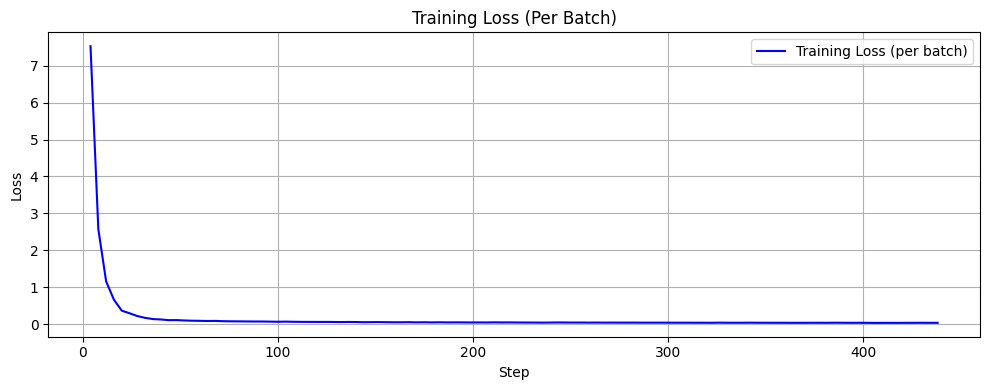

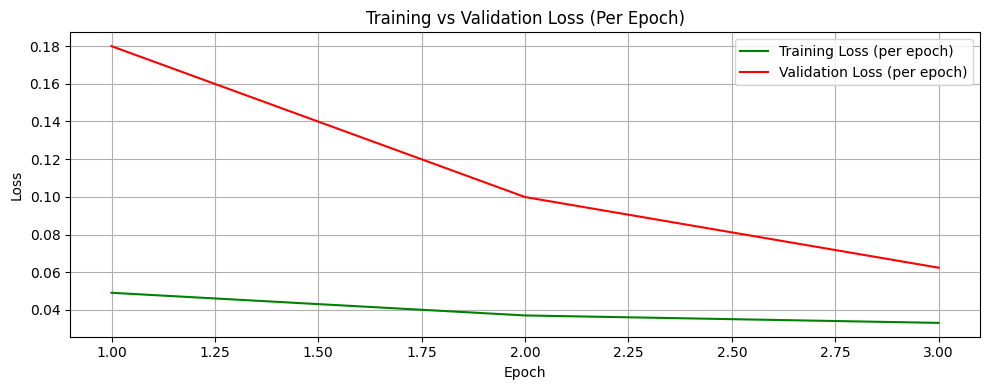

In [11]:
import json
import matplotlib.pyplot as plt


# Plot batch-level training loss
plt.figure(figsize=(10, 4))
plt.plot(loss_train['step'], loss_train['loss'], label='Training Loss (per batch)', color='blue')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss (Per Batch)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

if len(train_val_loss['ep']) > 1:
    # Plot epoch-level training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(train_val_loss['ep'], train_val_loss['train'], label='Training Loss (per epoch)', color='green')
    plt.plot(train_val_loss['ep'], train_val_loss['val'], label='Validation Loss (per epoch)', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss (Per Epoch)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Save the model

In [12]:
model2_path = '/kaggle/working/gpt2-genz-vocab'

model.save_pretrained(f'{model2_path}/')
tokenizer.save_pretrained(f'{model2_path}/')

# Save expanded vocabulary metadata
metadata = {
    "model_name": "gpt2-genz-slang",
    "base_model": "gpt2-finetuned-dictionary",
    "vocab_size": len(tokenizer),
    "original_vocab_size": 50257,  # Standard GPT2 vocab size
    "added_tokens": len(tokenizer) - 50257,
    "special_tokens": list(tokenizer.special_tokens_map.values()),
    "expansion_date": datetime.now().isoformat(),
    "description": "GPT2 model with expanded vocabulary for Gen-Z slang and custom terms"
}

with open(f'{model2_path}/training_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

# Also save the vocabulary mapping for reference
with open(f'{model2_path}/vocabulary_mapping.json', 'w') as f:
    json.dump(tokenizer.get_vocab(), f, indent=2)

model_card_content = """
# GPT2 with Expanded Vocabulary

This model is a GPT2 model with expanded vocabulary including Gen-Z slang and custom tokens.

## Model Details

- Base Model: GPT2 (finetuned on dictionary data)
- Vocabulary: Expanded with Gen-Z slang terms
- Special Tokens: Added [PAD] token + custom tokens
- Task: Text generation with expanded vocabulary understanding

## Usage

```python
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model = GPT2LMHeadModel.from_pretrained('path/to/model')
tokenizer = GPT2Tokenizer.from_pretrained('path/to/model')

# Generate text with expanded vocabulary
text = "This is so"
inputs = tokenizer(text, return_tensors='pt')
outputs = model.generate(**inputs, max_length=50)
print(tokenizer.decode(outputs[0]))
```

## Vocabulary Expansion

The model vocabulary has been expanded beyond the standard GPT2 vocabulary to include Gen-Z slang terms.

## Training Pipeline

1. Base GPT2 finetuned on dictionary word-definition pairs
2. Vocabulary expanded with new tokens
3. New token embeddings learned from contextual definitions
"""
    
with open(f'{model2_path}/README.md', 'w') as f:
    f.write(model_card_content)

## Save it on Kaggle

In [13]:
import kagglehub

kagglehub.login()


MODEL_SLUG = 'GPT2_GenZ_slang' # Replace with model slug.

# Learn more about naming model variations at
# https://www.kaggle.com/docs/models#name-model.
VARIATION_SLUG = 'default' # Replace with variation slug.

kagglehub.model_upload(
  handle = f"neelpatel31/{MODEL_SLUG}/pyTorch/{VARIATION_SLUG}",
  local_model_dir = model2_path,
  version_notes = 'Update 2025-05-31'
)

Uploading Model https://www.kaggle.com/models/neelpatel31/GPT2_GenZ_slang/pyTorch/default ...
Model 'GPT2_GenZ_slang' does not exist or access is forbidden for user 'neelpatel31'. Creating or handling Model...
Model 'GPT2_GenZ_slang' Created.
Starting upload for file /kaggle/working/gpt2-genz-vocab/generation_config.json


Uploading: 100%|██████████| 186/186 [00:00<00:00, 514B/s]

Upload successful: /kaggle/working/gpt2-genz-vocab/generation_config.json (186B)
Starting upload for file /kaggle/working/gpt2-genz-vocab/merges.txt



Uploading: 100%|██████████| 456k/456k [00:00<00:00, 1.21MB/s]

Upload successful: /kaggle/working/gpt2-genz-vocab/merges.txt (446KB)
Starting upload for file /kaggle/working/gpt2-genz-vocab/README.md



Uploading: 100%|██████████| 1.06k/1.06k [00:00<00:00, 3.01kB/s]

Upload successful: /kaggle/working/gpt2-genz-vocab/README.md (1KB)
Starting upload for file /kaggle/working/gpt2-genz-vocab/vocabulary_mapping.json



Uploading: 100%|██████████| 1.15M/1.15M [00:00<00:00, 3.22MB/s]

Upload successful: /kaggle/working/gpt2-genz-vocab/vocabulary_mapping.json (1MB)
Starting upload for file /kaggle/working/gpt2-genz-vocab/tokenizer_config.json



Uploading: 100%|██████████| 85.9k/85.9k [00:00<00:00, 244kB/s]

Upload successful: /kaggle/working/gpt2-genz-vocab/tokenizer_config.json (84KB)
Starting upload for file /kaggle/working/gpt2-genz-vocab/vocab.json



Uploading: 100%|██████████| 999k/999k [00:00<00:00, 2.50MB/s]

Upload successful: /kaggle/working/gpt2-genz-vocab/vocab.json (976KB)
Starting upload for file /kaggle/working/gpt2-genz-vocab/special_tokens_map.json



Uploading: 100%|██████████| 576/576 [00:00<00:00, 1.63kB/s]

Upload successful: /kaggle/working/gpt2-genz-vocab/special_tokens_map.json (576B)
Starting upload for file /kaggle/working/gpt2-genz-vocab/config.json



Uploading: 100%|██████████| 912/912 [00:00<00:00, 2.57kB/s]

Upload successful: /kaggle/working/gpt2-genz-vocab/config.json (912B)
Starting upload for file /kaggle/working/gpt2-genz-vocab/training_metadata.json



Uploading: 100%|██████████| 401/401 [00:00<00:00, 1.09kB/s]

Upload successful: /kaggle/working/gpt2-genz-vocab/training_metadata.json (401B)
Starting upload for file /kaggle/working/gpt2-genz-vocab/added_tokens.json



Uploading: 100%|██████████| 8.69k/8.69k [00:00<00:00, 24.3kB/s]

Upload successful: /kaggle/working/gpt2-genz-vocab/added_tokens.json (8KB)
Starting upload for file /kaggle/working/gpt2-genz-vocab/model.safetensors



Uploading: 100%|██████████| 499M/499M [00:03<00:00, 130MB/s]  

Upload successful: /kaggle/working/gpt2-genz-vocab/model.safetensors (476MB)


Your model instance has been created.
Files are being processed...
See at: https://www.kaggle.com/models/neelpatel31/GPT2_GenZ_slang/pyTorch/default


# Evaluate

In [ ]:
import torch
import random
import json
from tqdm import tqdm
from transformers import (
    AutoTokenizer, 
    GPT2LMHeadModel, 
    AutoModelForCausalLM
)
from torch.nn import functional as F


# Average Embedding for Baseline Approach credit to John Hewitt
# Source: https://nlp.stanford.edu/~johnhew/vocab-expansion.html

class VocabularyExpansionEvaluator:
    def __init__(self, model_path):
        # self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = GPT2LMHeadModel.from_pretrained(model_path)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    
    def expand_vocabulary_baseline(self, words_to_add):
        """
        Expand vocabulary using statistical baseline approach
        """
        # Store original embeddings before expansion
        pre_expansion_embeddings = self.model.get_input_embeddings().weight.clone()
        print(f"Original vocabulary size: {len(pre_expansion_embeddings)}")
        
        # Add new tokens and resize model
        self.tokenizer.add_tokens(words_to_add)
        self.model.resize_token_embeddings(len(self.tokenizer))
        
        # Get expanded embeddings
        embeddings = self.model.get_input_embeddings().weight
        print(f"Expanded vocabulary size: {len(embeddings)}")
        
        # Calculate statistics from original embeddings
        mu = torch.mean(pre_expansion_embeddings, dim=0)
        n = pre_expansion_embeddings.size()[0]
        
        # Calculate covariance matrix
        centered_embeddings = pre_expansion_embeddings - mu
        ## Center the embeddings by subtracting the mean

        sigma = (centered_embeddings.T @ centered_embeddings) / n
        ## sigma captures how embedding dimensions vary and correlate with each other.


        # Create multivariate normal distribution
        dist = torch.distributions.multivariate_normal.MultivariateNormal(
            mu, covariance_matrix=1e-5 * sigma
        )
        ## 1e-5 multiplier significantly reduces the variance:
        ## Without scaling: new embeddings would have the same variance as existing ones, potentially creating very different/extreme embeddings.
        ## With 1e-5 scaling: new embeddings are generated close to the mean, creating more conservative initialization.
        ## This prevents new words from having embeddings that are too far from the typical embedding space.
        ## Intution: "I don't know what these new slang words should look like, but I'll make them similar to the average word embeddings,
        ## just with slight variations that respect how existing words vary from each other."
        
        # Sample embeddings for new words
        num_new_words = len(words_to_add)
        with torch.no_grad():
            new_embeddings = torch.stack([
                dist.sample() for _ in range(num_new_words)
            ], dim=0)
            # Assign to last positions (where new tokens were added)
            embeddings[-num_new_words:, :] = new_embeddings
            
        print(f"Initialized {num_new_words} new word embeddings using statistical baseline")
    
    def evaluate_word_prediction(self, df, sample_size=50):
        """
        Evaluate model's ability to predict correct words given definitions
        """
        # Initialize counters
        total_1 = total_5 = total_10 = total_25 = 0
        rank_total = counter = 0
        vocab = self.tokenizer.vocab
        
        print(f"Evaluating on {len(df)} examples...")
        
        for i in tqdm(range(len(df))):

            word = df.loc[i, 'Slang']
            example = df.loc[i, 'Example']

            
            # Skip if word not in vocabulary
            if word not in vocab:
                print(f"\nWord '{word}' not in vocabulary, skipping...")
                continue
                
            element_index = vocab[word]
            
            # Tokenize and find word position
            input_tokens = self.tokenizer.encode(example, return_tensors="pt")
            
            try:
                # Find position of target word in the tokenized sequence
                mask_index = torch.nonzero(
                    input_tokens[0] == element_index, as_tuple=True
                )[0][0]
            except (IndexError, RuntimeError) as e:
                print(f"\nCould not find word '{word}' in tokenized sequence, skipping...")
                continue
            
            # Create test scenarios
            vocab_size = self.tokenizer.vocab_size
            sentences = [input_tokens[0].clone() for _ in range(sample_size)]
            
            # Replace target word with random words in 49 sentences
            rand_indices = random.sample(range(vocab_size), sample_size - 1)
            for i in range(sample_size - 1):
                sentences[i][mask_index] = rand_indices[i]
            
            # Keep original word in the last sentence
            sentences[-1][mask_index] = element_index
            
            # Stack all sentences for batch processing
            sentence_batch = torch.stack(sentences)
            
            # Get model predictions
            try:
                with torch.no_grad():
                    outputs = self.model(sentence_batch, labels=sentence_batch)
                    logits = outputs.logits
                    
                    # Get logits for the masked position
                    mask_logits = logits[:, mask_index, :]
                    
                    # Sum probabilities across vocabulary dimension
                    probs = mask_logits.sum(dim=-1).squeeze()
                    
                    # Rank sentences by probability
                    sorted_indices = torch.argsort(probs, descending=True)
                    
                    # Find rank of correct sentence (last one, index sample_size-1)
                    element_rank = (sorted_indices == sample_size - 1).nonzero(as_tuple=True)[0].item() + 1
                    
            except Exception as e:
                print(f"\nError during model inference: {e}")
                print(f"Could not find word '{word}' in tokenized sequence")
                print(f"Example: {example}")
                print(f"Tokens: {self.tokenizer.convert_ids_to_tokens(input_tokens[0])}")
                print(f"Target token ID: {element_index}")
                print("---")
                continue
            
            # Update statistics
            rank_total += element_rank
            if element_rank <= 1:
                total_1 += 1
            if element_rank <= 5:
                total_5 += 1
            if element_rank <= 10:
                total_10 += 1
            if element_rank <= 25:
                total_25 += 1
            counter += 1
        
        # Print results
        if counter > 0:
            print("\n=== Evaluation Results ===")
            print(f"Total examples evaluated: {counter}")
            print(f"Top-1 accuracy: {total_1}/{counter} ({100*total_1/counter:.2f}%)")
            print(f"Top-5 accuracy: {total_5}/{counter} ({100*total_5/counter:.2f}%)")
            print(f"Top-10 accuracy: {total_10}/{counter} ({100*total_10/counter:.2f}%)")
            print(f"Top-25 accuracy: {total_25}/{counter} ({100*total_25/counter:.2f}%)")
            print(f"Average rank: {rank_total/counter:.2f}")
        else:
            print("No examples were successfully evaluated!")
        
        return {
            'top_1': total_1,
            'top_5': total_5,
            'top_10': total_10,
            'top_25': total_25,
            'avg_rank': rank_total / counter if counter > 0 else 0,
            'total_evaluated': counter
        }

## Evaluate the GPT2 (Vocab expansion using statistical approach)

In [15]:
evaluator = VocabularyExpansionEvaluator(model1_path)

words_to_add = []
with open('added_slang.txt', 'r') as f:
    words_to_add = f.read().split("\n")


evaluator.expand_vocabulary_baseline(words_to_add)
    
results = evaluator.evaluate_word_prediction(gen_z_vocab_df)

with open('gpt2_eval_result_baseline.json', 'w') as f:
    f.write(json.dumps(results))


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


Original vocabulary size: 50258
Expanded vocabulary size: 50736
Initialized 512 new word embeddings using statistical baseline
Evaluating on 512 examples...


  0%|          | 2/512 [00:02<10:27,  1.23s/it]


Could not find word 'breadcumbing' in tokenized sequence, skipping...


  4%|▍         | 21/512 [00:20<08:33,  1.05s/it]


Could not find word 'rotflmao' in tokenized sequence, skipping...


  5%|▍         | 25/512 [00:23<07:07,  1.14it/s]


Could not find word 'ghosting' in tokenized sequence, skipping...


  7%|▋         | 35/512 [00:32<07:29,  1.06it/s]


Could not find word 'l+ratio' in tokenized sequence, skipping...


 12%|█▏        | 61/512 [00:55<08:13,  1.09s/it]


Could not find word 'g.o.a.t' in tokenized sequence, skipping...


 48%|████▊     | 248/512 [03:41<04:53,  1.11s/it]


Could not find word 'qpsa?' in tokenized sequence, skipping...


100%|██████████| 512/512 [07:31<00:00,  1.13it/s]


=== Evaluation Results ===
Total examples evaluated: 506
Top-1 accuracy: 36/506 (7.11%)
Top-5 accuracy: 161/506 (31.82%)
Top-10 accuracy: 281/506 (55.53%)
Top-25 accuracy: 492/506 (97.23%)
Average rank: 10.19


## Evaluate the GPT2 (Vocab expansion using the defintion)

In [16]:
evaluator = VocabularyExpansionEvaluator(model2_path)

# Example: Evaluate on dataset
results = evaluator.evaluate_word_prediction(gen_z_vocab_df)

with open('gpt2_eval_result.json', 'w') as f:
    f.write(json.dumps(results))


Evaluating on 512 examples...


  0%|          | 2/512 [00:02<09:28,  1.11s/it]


Could not find word 'breadcumbing' in tokenized sequence, skipping...


  4%|▍         | 21/512 [00:19<08:01,  1.02it/s]


Could not find word 'rotflmao' in tokenized sequence, skipping...


  5%|▍         | 25/512 [00:21<06:23,  1.27it/s]


Could not find word 'ghosting' in tokenized sequence, skipping...


  7%|▋         | 35/512 [00:31<07:55,  1.00it/s]


Could not find word 'l+ratio' in tokenized sequence, skipping...


 12%|█▏        | 61/512 [00:52<06:41,  1.12it/s]


Could not find word 'g.o.a.t' in tokenized sequence, skipping...


 48%|████▊     | 248/512 [03:37<04:28,  1.02s/it]


Could not find word 'qpsa?' in tokenized sequence, skipping...


100%|██████████| 512/512 [07:26<00:00,  1.15it/s]


=== Evaluation Results ===
Total examples evaluated: 506
Top-1 accuracy: 270/506 (53.36%)
Top-5 accuracy: 451/506 (89.13%)
Top-10 accuracy: 486/506 (96.05%)
Top-25 accuracy: 499/506 (98.62%)
Average rank: 3.04
